# Building an Accounting Fraud Classification Model

## Abstract
I built a Machine Learning model to detect accounting fraud. My model achieved its best metrics with a Gradient Boosting Classifier: .99 AUC; .85 F1 Score; .91 Cross Validation; and .96 Accuracy.

## Motivation

On both a federal and international level, we spend a lot of money on [compliance costs,](https://www.investopedia.com/terms/c/compliance-cost.asp) including adherence to anti-fraud regulation, such as the [Sarbanes-Oxley Act of 2002](https://www.thebalance.com/sarbanes-oxley-act-of-2002-3306254). Despite all the regulation put in place to disincentivize fraud, companies and executives continue to commit accounting fraud. I wanted to introduce machine learning to this continuing issue as a first measure to catch potential fraud and also possibly deter it.

## Research
First, I needed to find the companies that had actually committed fraud. I did this by combing through the Securities and Exchange Commission's (SEC) [Press Releases](https://www.sec.gov/news/pressreleases) for the last 5 years to gather a list of [25 companies](https://docs.google.com/spreadsheets/d/1BZbBUqk-sBsjPD53e2lGlSAdQGcFJFy6ULFqSY_wypM/edit?usp=sharing) that had been accused of fraud by the SEC. There, I had access to the SEC orders that specified which financial statements were deemed fraudulent, when they had previously been filed, and the companies' CIK numbers (a unique identifier assigned to each corporation).

## Dataset

Then, I downloaded the [Financial Statement Data Sets](https://www.sec.gov/dera/data/financial-statement-data-sets.html) containing the above mentioned fraudulent filings as well as some non-fraudulent filings.

In [80]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
np.random.seed(0)
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#Listing of fraudulent companies and adshs
frauds = pd.read_csv('csv files/listing_accountingfrauds.csv')
frauds.head()

,comp_name,related_qtr,adsh,filing_type,fraud
0,Logitech International,2q13,0001047469-13-006614,10k,1
1,Logitech International,2q11,0001193125-11-153485,10k,1
2,Logitech International,2q12,0001047469-12-006385,10k,1
3,Ener1 Inc,1Q11,0001144204-11-014018,10k,1
4,Ener1 Inc,2Q11,0001144204-11-027657,10q,1


In [46]:
#get all quarters' info
master_df = pd.DataFrame([])
quarter_listing = pd.read_csv('quarter_listings.csv').File.str.lower().tolist()
for quarter in quarter_listing:
    df = pd.read_csv('numsbyquarter/'+quarter+'/num.txt',  sep='\t',encoding ='latin1')
    master_df = master_df.append(df)

In [47]:
master_df.head()

,adsh,tag,version,coreg,ddate,qtrs,uom,value,footnote
0,0000008868-16-000183,AccountsPayableCurrent,us-gaap/2015,NaN,20141231,0,USD,806300000.0,NaN
1,0000008868-16-000183,AccountsPayableCurrent,us-gaap/2015,NaN,20151231,0,USD,774200000.0,NaN
2,0000016918-16-000101,AccountsPayableCurrent,us-gaap/2015,NaN,20160229,0,USD,429300000.0,NaN
3,0000016918-16-000101,AccountsPayableCurrent,us-gaap/2015,NaN,20160831,0,USD,624500000.0,NaN
4,0000016918-16-000101,AccountsPayableCurrent,us-gaap/2015,ParentCompany,20160229,0,USD,37700000.0,NaN


In [50]:
#index both DFs on adsh to merge
master_df = master_df.set_index('adsh')
frauds = frauds.set_index('adsh')

#explore which numbers are typically missing
master_df.isnull().sum()

tag                0
version            0
coreg       57163193
ddate              0
qtrs               0
uom                0
value        1468077
footnote    64785328
dtype: int64

In [51]:
#drop columns with blanks
master_df = master_df.drop(columns=['footnote','coreg'])
master_df = master_df.dropna()

#Get all data for fraudulent filings (fraud:1)
frauds = frauds.join(master_df)
frauds = frauds.dropna()

#Get data for non fraudulent filings (fraud:0)
df = pd.read_csv('numsbyquarter/2018q1/num.txt', sep='\t',encoding ='latin1')
df = df.drop(columns=['footnote','coreg'])
df = df.dropna()

#combine 2 DFs
combined = frauds.append(df)

## Feature Engineering

### 1. Benford's Law
Once I had my dataset, I added [Benford's Law](https://medium.com/@erika.russi/benny-and-the-di-gits-e6bb9f40c552) as my first feature. Benford's Law is the "Mathematical theory of leading digits. Specifically, in data sets, the leading digits are distributed in a specific, nonuniform way."

In [4]:
#convert monetary numbers to string and extract first digit
benford_df = df[['adsh','value']]
benford_df['abs_value'] = benford_df.value.abs()
benford_df['string'] = benford_df.abs_value.astype(str)
benford_df['first_digit'] = benford_df.string.str[0].astype(int)
benford_df.head()

,adsh,value,abs_value,string,first_digit
0,0000023082-10-000036,6.360000e+08,6.360000e+08,636000000.0,6
1,0000023082-10-000036,4.090000e+08,4.090000e+08,409000000.0,4
2,0000023082-10-000036,1.264000e+09,1.264000e+09,1264000000.0,1
3,0000023082-10-000036,1.344000e+09,1.344000e+09,1344000000.0,1
4,0000023082-10-000036,-3.417000e+09,3.417000e+09,3417000000.0,3


In [6]:
benford_df = benford_df[['adsh','first_digit']]
benford_pivot = benford_df.pivot_table(index='adsh', columns='first_digit', values='first_digit', aggfunc=np.count_nonzero)
benford_pivot = benford_pivot.fillna(0)
benford_pivot = benford_pivot.drop(benford_pivot.columns[0], axis=1)
totals= benford_pivot.sum(axis=1) #creates variable for total counts
benford_pivot.head()

first_digit,1,2,3,4,5,6,7,8,9
adsh,,,,,,,,,
0000002178-18-000009,284.0,162.0,142.0,88.0,66.0,56.0,52.0,56.0,38.0
0000002488-18-000042,372.0,212.0,150.0,86.0,70.0,68.0,78.0,60.0,66.0
0000002969-18-000014,220.0,112.0,76.0,40.0,36.0,34.0,30.0,22.0,26.0
0000003499-18-000006,158.0,116.0,126.0,66.0,62.0,16.0,40.0,56.0,20.0
0000003545-18-000021,166.0,54.0,50.0,48.0,16.0,16.0,10.0,34.0,6.0


In [14]:
freqs = (benford_pivot.T/totals).T
freqs.head()

first_digit,1,2,3,4,5,6,7,8,9
adsh,,,,,,,,,
0000002178-18-000009,0.300847,0.171610,0.150424,0.093220,0.069915,0.059322,0.055085,0.059322,0.040254
0000002488-18-000042,0.320138,0.182444,0.129088,0.074010,0.060241,0.058520,0.067126,0.051635,0.056799
0000002969-18-000014,0.369128,0.187919,0.127517,0.067114,0.060403,0.057047,0.050336,0.036913,0.043624
0000003499-18-000006,0.239394,0.175758,0.190909,0.100000,0.093939,0.024242,0.060606,0.084848,0.030303
0000003545-18-000021,0.415000,0.135000,0.125000,0.120000,0.040000,0.040000,0.025000,0.085000,0.015000


#### If a company had committed fraud, then the frequency of leading digits from their financial statements should stray from the theoretical numbers, and when graphing the numbers, it appeared to be the case:


<p align="left">
<img src="images/benford_frauds.png">

#### I used the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) as a single measurement of how much a company's filing actually strayed from Benford's Law.

In [26]:
#theoretical Benford numbers

benfords_law = pd.DataFrame([math.log10(1 + 1/digit) for digit in range(1,10)]).T
benfords_law.columns = list(range(1,10))   
benfords_law

,1,2,3,4,5,6,7,8,9
0,0.30103,0.176091,0.124939,0.09691,0.079181,0.066947,0.057992,0.051153,0.045757


In [73]:
#create a ratio of the empirical numbers to the theoretical numbers

ratio = np.log10(pd.DataFrame(freqs.values/benfords_law.values))
ratio.columns = list(range(1,10))   
ratio.head()

,1,2,3,4,5,6,7,8,9
0,-0.000263,-0.011195,0.080619,-0.016858,-0.054050,-0.052514,-0.022336,0.064349,-0.055651
1,0.026727,0.015392,0.014188,-0.117076,-0.118730,-0.058427,0.063521,0.004078,0.093876
2,0.088567,0.028234,0.008870,-0.159555,-0.117566,-0.069497,-0.061493,-0.141691,-0.020735
3,-0.099497,-0.000824,0.184129,0.013631,0.074225,-0.441154,0.019148,0.219777,-0.178976
4,0.139438,-0.115404,0.000213,0.092813,-0.296562,-0.223670,-0.365428,0.220552,-0.484371


In [74]:
#sum of all ratios
kldiv = pd.DataFrame((freqs*ratio.values).sum(axis=1))
kldiv.head()

,0
adsh,
0000002178-18-000009,0.002008
0000002488-18-000042,0.003766
0000002969-18-000014,0.008125
0000003499-18-000006,0.023214
0000003545-18-000021,0.034988


### 2. Financial Statement Tags
The next features I wanted to include were tags used within the financial statements. I bucketed common tags/account names listed on financial statements using repeating patterns. For instance, if the phrase "Accounts Receivable" occured in the Balance Sheet, the account should be tagged as such even if it read "Trade accounts receivable, net". I found common tags across three financial statements: Balance Sheet, Income Statement, and Statement of Cash flows.

<p align="left">
<img src="images/fin_statement.png">

In [87]:
combined.head()

,adsh,ddate,fraud,qtrs,tag,uom,value,version
0,0000023082-10-000036,20090331.0,1.0,0.0,AccountsPayableCurrent,USD,6.360000e+08,us-gaap/2009
1,0000023082-10-000036,20100331.0,1.0,0.0,AccountsPayableCurrent,USD,4.090000e+08,us-gaap/2009
2,0000023082-10-000036,20090331.0,1.0,0.0,AccruedLiabilitiesCurrent,USD,1.264000e+09,us-gaap/2009
3,0000023082-10-000036,20100331.0,1.0,0.0,AccruedLiabilitiesCurrent,USD,1.344000e+09,us-gaap/2009
4,0000023082-10-000036,20090331.0,1.0,0.0,AccumulatedDepreciationDepletionAndAmortizatio...,USD,-3.417000e+09,us-gaap/2009


#### Below, I found consistent patterns in the three financial statements so I could bucket the tags and be able to compare companies against each other. I checked a couple of hundred results to ensure that the tags were not being incorrectly bucketed. The number of unique tags was originally 132,350.

In [90]:
# CashFlowfromOps
combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains("financingactivit|financeact|noncash")].
                                            index, 'tag', 'NotCash_Catch')

op_ativities_cash = "operatingactivi|operationactivit|operatingcash"

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(op_ativities_cash)].
                                            index, 'tag', 'CashFlowfromOps')

#Depreciation
combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains('depreciation')].
                                            index, 'tag', 'Depreciation')
# intangibles
intangibles = 'goodwill|intangible|trademark|royalt|software|patent|copyright|license|customerlist'
combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(intangibles)].
                                            index, 'tag', 'IntangibleAssets')
#AccountsReceivable, OtherCurrentAssets
accounts_rec = "accountsrec|accountrec|receivable|uncollectible|allowancefor"
other_current_assets = "inventor|asset|taxben|prepaid|fairval|taxexpensebenefit"

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(accounts_rec)].
                                            index, 'tag', 'AccountsReceivable')

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(other_current_assets)].
                                            index, 'tag', 'OtherCurrentAssets')

#PPE,
PPE = "land|properties|property|building|leaseh|lease-h|rental|equipment|machinery|longtermasset"

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(PPE)].
                                            index, 'tag', 'PPE')


#currentliabilities,other liabilities
current_liabilities = "payable|short-term|currentliab|currentmatur|currentport|accrued|deferredinc"



combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(current_liabilities)].
                                            index, 'tag', 'CurrentLiabilities')

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains("salesecurities")].
                                            index, 'tag', 'NotSales_Catch')


#sales, expenses#otherincome
sales = "revenue|sales"

expenses = "costof|taxespaid|services|costsof|research|expense|admin|cost|compensat|charge|settlement|deplet|accretion|amortiz"


other_income = "proceeds"

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(sales)].
                                            index, 'tag', 'Sales')

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(expenses)].
                                            index, 'tag', 'Expenses')

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(other_income)].
                                            index, 'tag', 'OtherIncome')

#Cash
cash = "cash|cashequiv|commercialpaper|cashand"
combined = combined.set_value(combined.loc[combined['tag'].str.contains(cash)].
                                            index, 'tag', 'Cash')

#shareholdersequity
shareholders = "othercompre|shareholder|paid-in|capital|controlling|equity|retained|orityinterest|stock|accumulateddeficit"

combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(shareholders)].
                                            index, 'tag', 'ShareholdersEquity')
other_liabilities = 'long-term|debt|liabilit|lineofcredit|provision|contingen'
combined = combined.set_value(combined.loc[combined['tag'].
                                                                str.contains(other_liabilities)].
                                            index, 'tag', 'OtherLiabilities')


In [91]:
bucket_tags = ['Depreciation', 'CurrentLiabilities' , 'PPE', 'ShareholdersEquity','AccountsReceivable', 
               'OtherCurrentAssets','IntangibleAssets','Cash','Expenses','OtherLiabilities','Sales',
               'CashFlowfromOps','OtherIncome']

combined = combined[combined['tag'].isin(bucket_tags)]

for i in bucket_tags:
    print(i, len(combined.loc[combined['tag'] == i ]))

Depreciation 44936
CurrentLiabilities 105753
PPE 101515
ShareholdersEquity 367695
AccountsReceivable 103530
OtherCurrentAssets 431284
IntangibleAssets 87554
Cash 103168
Expenses 350768
OtherLiabilities 156649
Sales 81484
CashFlowfromOps 24247
OtherIncome 62724


In [98]:
df_for_pivot = combined.drop(columns= ['2ndindex', 'qtrs', 'uom','version'])
combined_pivot =pd.pivot_table(df_for_pivot,index=['fraud',"adsh","ddate",], columns= ['tag'], values= ['value'], aggfunc='sum')
combined_pivot = combined_pivot.fillna(0)
combined_pivot.head()

value              \
tag                                   AccountsReceivable        Cash   
fraud adsh                 ddate                                       
0.0   0000002178-18-000009 20141231.0           179000.0  80184000.0   
                           20151231.0        -70682000.0  97210000.0   
                           20160331.0                0.0         0.0   
                           20160630.0                0.0         0.0   
                           20160930.0                0.0         0.0   

                                                                          \
tag                                   CashFlowfromOps CurrentLiabilities   
fraud adsh                 ddate                                           
0.0   0000002178-18-000009 20141231.0             0.0                0.0   
                           20151231.0      23208000.0        -87570000.0   
                           20160331.0             0.0                0.0   
                           20160630.0             0.0                0.0   
                           20160930.0             0.0                0.0   

                                                                  \
tag                                   Depreciation      Expenses   
fraud adsh                 ddate                                   
0.0   0000002178-18-000009 20141231.0          0.0  0.000000e+00   
                           20151231.0   28783000.0  3.853222e+09   
                           20160331.0          0.0  0.000000e+00   
                           20160630.0          0.0  0.000000e+00   
                           20160930.0          0.0  0.000000e+00   

                                                                           \
tag                                   IntangibleAssets OtherCurrentAssets   
fraud adsh                 ddate                                            
0.0   0000002178-18-000009 20141231.0              0.0          2464000.0   
                           20151231.0              0.0        -14538000.0   
                           20160331.0              0.0                0.0   
                           20160630.0              0.0                0.0   
                           20160930.0              0.0                0.0   

                                                                    \
tag                                   OtherIncome OtherLiabilities   
fraud adsh                 ddate                                     
0.0   0000002178-18-000009 20141231.0         0.0              0.0   
                           20151231.0         0.0         143000.0   
                           20160331.0         0.0              0.0   
                           20160630.0         0.0              0.0   
                           20160930.0         0.0              0.0   

                                                                  \
tag                                            PPE         Sales   
fraud adsh                 ddate                                   
0.0   0000002178-18-000009 20141231.0   15744000.0  0.000000e+00   
                           20151231.0  140612000.0  4.345984e+09   
                           20160331.0          0.0  2.505310e+08   
                           20160630.0          0.0  2.931630e+08   
                           20160930.0          0.0  2.568770e+08   

                                                          
tag                                   ShareholdersEquity  
fraud adsh                 ddate                          
0.0   0000002178-18-000009 20141231.0       1.574970e+08  
                           20151231.0       1.508970e+08  
                           20160331.0       1.554000e+06  
                           20160630.0       3.540000e+06  
                           20160930.0      -9.830003e+05

In [122]:
adsh = combined.groupby(['adsh','fraud'])[bucket_tags].sum()
adsh.head()

,,Depreciation,CurrentLiabilities,PPE,ShareholdersEquity,AccountsReceivable,OtherCurrentAssets,IntangibleAssets,Cash,Expenses,OtherLiabilities,Sales,CashFlowfromOps,OtherIncome
adsh,fraud,,,,,,,,,,,,,
0000002178-18-000009,0.0,3.608060e+08,2.057540e+08,8.291780e+08,1.457668e+09,1.939190e+08,1.024242e+09,0.000000e+00,3.910830e+08,8.634819e+09,4.620100e+08,1.212192e+10,5.484600e+07,7.475000e+06
0000002488-18-000042,0.0,2.143000e+09,7.206000e+09,6.962000e+09,9.619000e+09,3.670000e+08,3.914400e+10,1.123200e+10,4.719000e+09,2.505300e+10,1.280200e+10,3.714300e+10,-6.800000e+07,2.399000e+09
0000002969-18-000014,0.0,2.294970e+10,4.203800e+09,5.754450e+10,1.308377e+11,2.337100e+09,8.011260e+10,5.649300e+09,1.333080e+10,4.373600e+09,3.811890e+10,6.356900e+09,1.091700e+09,-5.577000e+08
0000003499-18-000006,0.0,8.263830e+09,2.394690e+09,5.993879e+09,6.432446e+09,1.797337e+09,3.823019e+09,0.000000e+00,2.928676e+09,8.957640e+08,4.275348e+09,1.565924e+09,3.604470e+08,8.264650e+08
0000003545-18-000021,0.0,7.406000e+06,2.743400e+07,7.720630e+08,1.895754e+09,3.092700e+07,1.066886e+09,4.492000e+06,4.077000e+06,3.747720e+08,2.027521e+09,6.879300e+07,-2.657900e+07,3.967600e+07


### 3.  Financial Ratios
Finally, I added financial ratios typically used by forensic accountants to detect fraud. I also included the [Total Accruals to Total Assets (TATA)](https://www.gmtresearch.com/beneishs-m-score/), Asset Quality Index (AQI), and Depreciation (DEPI) ratios. 

<p align="left">
<img src="images/finratios.png">


In [ ]:
adsh['TotalCurrentAssets'] = adsh.AccountsReceivable+adsh.Cash+adsh.OtherCurrentAssets
adsh['CurrentRatio'] = adsh.TotalCurrentAssets/adsh.CurrentLiabilities
adsh['TotalLiabilities'] = adsh.CurrentLiabilities+adsh.OtherLiabilities
adsh['DebtToEquityRatio'] = adsh.TotalLiabilities/adsh.ShareholdersEquity
adsh['NetIncome'] = adsh.Sales - adsh.Expenses
adsh['ProfitMargin'] = adsh.NetIncome/adsh.Sales #similar to GMI
adsh['ReceivableTurnover'] = adsh.Sales/adsh.AccountsReceivable
adsh['CollectionRatio'] = 365/adsh.ReceivableTurnover
adsh['DSRI'] = adsh.AccountsReceivable/adsh.Sales
adsh['TotalAssets'] = adsh.TotalCurrentAssets+adsh.IntangibleAssets+adsh.PPE
adsh['AQI'] = 1-((adsh.TotalCurrentAssets+adsh.PPE)/adsh.TotalAssets)
adsh['DEPI'] = adsh.Depreciation/(adsh.Depreciation+adsh.PPE)
adsh['TATA'] = (adsh.NetIncome-adsh.CashFlowfromOps)/adsh.TotalAssets

In [7]:
adsh.head()

,fraud,ddate,AccountsReceivable,Cash,CashFlowfromOps,CurrentLiabilities,Depreciation,Expenses,IntangibleAssets,OtherCurrentAssets,...,DebtToEquityRatio,NetIncome,ProfitMargin,ReceivableTurnover,CollectionRatio,DSRI,TotalAssets,AQI,DEPI,TATA
adsh,,,,,,,,,,,,,,,,,,,,,
0000002178-18-000009,0.0,20161231.0,106756000.0,7.875000e+07,6504000.0,1.114280e+08,2.210870e+08,2.163510e+09,0.0,4.751370e+08,...,0.539227,6.440080e+08,0.229387,26.298456,13.879142,0.038025,1.139030e+09,0.000000,0.316076,0.559690
0000002488-18-000042,0.0,20161231.0,126000000.0,2.010000e+09,90000000.0,3.825000e+09,9.210000e+08,6.611000e+09,948000000.0,2.048300e+10,...,1.464384,3.287000e+09,0.332087,78.555556,4.646393,0.012730,2.617100e+10,0.036223,0.261277,0.122158
0000002969-18-000014,0.0,20161231.0,-57400000.0,5.735000e+08,525400000.0,1.040000e+07,2.061000e+08,1.587700e+09,0.0,1.100000e+08,...,0.003057,2.948000e+08,0.156600,-32.796167,-11.129349,-0.030491,1.062500e+09,0.000000,0.320778,-0.217035
0000003499-18-000006,0.0,20161231.0,182581000.0,8.456940e+08,130820000.0,1.110608e+09,1.655981e+09,3.176400e+08,0.0,1.490230e+09,...,0.822055,1.179930e+08,0.270854,2.385971,152.977541,0.419117,5.371457e+09,0.000000,0.367267,-0.002388
0000003545-18-000021,0.0,20161231.0,7177000.0,-6.183000e+06,-16890000.0,-4.823000e+06,3.916000e+06,3.149000e+06,0.0,-7.200000e+04,...,2.353128,2.942400e+07,0.903325,4.538526,80.422589,0.220336,7.572000e+06,0.000000,0.370623,6.116482


## Feature Selection
Once completed, I had added 28 features to my dataset. However, with the use of financial ratios and their potentially high correlation to related features, such as the account statement tags, I needed to remove overly correlated variables to avoid an overfit model. I dropped features with correlation greater than .7 and had 21 features remaining.

In [11]:
target = adsh.fraud
features = adsh.drop(['adsh','ddate','fraud'], axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

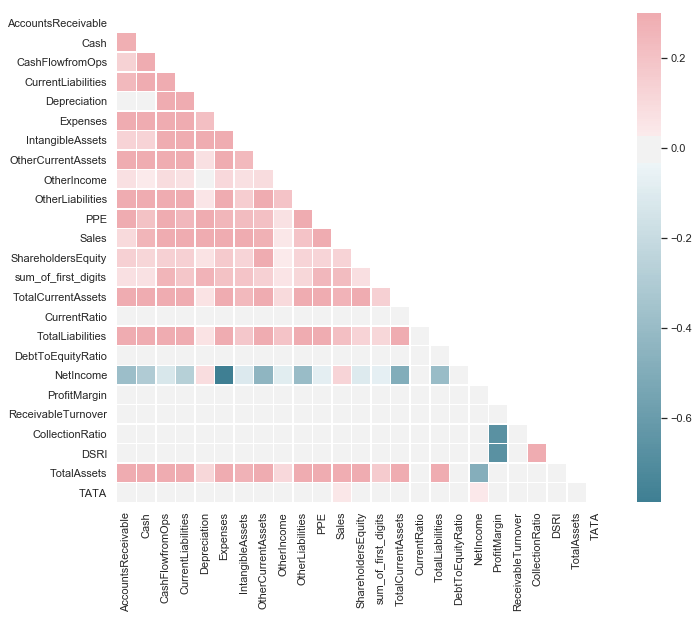

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)
thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

features_selected_train = variance_threshold_selector(X_train)

# Compute the correlation matrix
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})

In [18]:
def calculate_cols_to_drop(upper):
    #to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    shape = upper.shape
    print(shape)
    row_index = upper.index
    col_index = upper.columns
    to_drop = []
    
    for row in range(0, shape[0]):
        for col in range(0, shape[1]):
            #print(upper.iloc[row,col])
            if upper.iloc[row, col] > 0.7:
                if row_index[row] in to_drop or col_index[col] in to_drop:
                    pass
                else:
                    to_drop.append(col_index[col])
    return to_drop

corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix (so as not to include self-correlations of 1)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

features_selected_train.drop(columns=to_drop, inplace=True)

to_drop

['OtherLiabilities',
 'PPE',
 'TotalCurrentAssets',
 'TotalLiabilities',
 'NetIncome',
 'DSRI',
 'TotalAssets']

## Modeling and Results

In order to find the best model and its parameters, I used [TPOT](https://epistasislab.github.io/tpot/using/), an automated machine learning algorithm. After running several iterations with different generation numbers, population sizes, and k-fold cross-validation amounts, TPOT optimized the best model as a Gradient Boosting Classifier.

Compared to the baseline Dummy Classifier model, the Gradient Boosting Model was very successful.

<p align="left">
<img width="600" alt="results" src="images/results.png">

### Dummy Classifier

In [47]:
target = df.fraud
fraud = df[['adsh','fraud']]
df = df.set_index('adsh')
fraud = fraud.set_index('adsh')
df = df.drop(['fraud'], axis=1)
df.head()

,AccountsReceivable,Cash,CashFlowfromOps,CurrentLiabilities,Depreciation,Expenses,IntangibleAssets,OtherCurrentAssets,OtherIncome,Sales,...,LengthOfFinStmt,DeviationFromBenford,CurrentRatio,DebtToEquityRatio,ProfitMargin,ReceivableTurnover,CollectionRatio,AQI,DEPI,TATA
adsh,,,,,,,,,,,,,,,,,,,,,
0000002178-18-000009,-0.049149,-0.047866,-0.188882,-0.115455,-0.133843,-0.093800,-0.15116,-0.077214,-0.066630,-0.093298,...,-0.002642,-0.433615,-0.013285,-0.013332,0.027361,-0.015921,-0.020880,-0.225344,0.271118,0.043936
0000002488-18-000042,-0.049063,0.039445,-0.155622,0.110438,-0.053649,0.001734,-0.09378,-0.030408,-0.040274,0.156840,...,0.351155,-0.370117,-0.013285,-0.013332,0.027402,0.026730,-0.020881,-0.124785,0.171077,-0.007698
0000002969-18-000014,-0.049886,-0.025498,0.017818,-0.121601,-0.135561,-0.106169,-0.15116,-0.078068,-0.079576,-0.125931,...,-0.567419,-0.212703,-0.013285,-0.013332,0.027331,-0.064152,-0.020882,-0.225344,0.279702,-0.047727
0000003499-18-000006,-0.048809,-0.013192,-0.139362,-0.054676,0.030564,-0.133451,-0.15116,-0.074839,-0.066710,-0.176973,...,-0.463552,0.332228,-0.013285,-0.013332,0.027377,-0.035438,-0.020870,-0.225344,0.364571,-0.022396
0000003545-18-000021,-0.049596,-0.051705,-0.198201,-0.122527,-0.158726,-0.140206,-0.15116,-0.078325,-0.066337,-0.191193,...,-0.885512,0.757414,-0.013285,-0.013332,0.027631,-0.033681,-0.020875,-0.225344,0.370698,0.699700


In [77]:
X_train, X_test, y_train, y_test = train_test_split(df, target)

dum_clf = DummyClassifier()
dum_clf.fit(X_train.as_matrix(), y_train.as_matrix())

dum_clf_train_preds = dum_clf.predict(X_train)
dum_clf_test_preds = dum_clf.predict(X_test)

def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    

print("Classification Report")
dum_classification_report = classification_report(y_test, dum_clf_test_preds)
print(dum_classification_report)
print("")
    
print("Training Metrics")
display_acc_and_f1_score(y_train, dum_clf_train_preds, model_name='Dummy Classifier')
print("")

print("Testing Metrics")
display_acc_and_f1_score(y_test, dum_clf_test_preds, model_name='Dummy Classifier')
print("")

print("Confusion Matrix")
dum_confusion_matrix = confusion_matrix(y_test, dum_clf_test_preds)
print(dum_confusion_matrix)
print("")

print('Mean Dum Cross-Val Score (k=5):')
print(cross_val_score(dum_clf, df, target, cv=5).mean())

Classification Report
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      1263
         1.0       0.10      0.10      0.10       189

   micro avg       0.77      0.77      0.77      1452
   macro avg       0.49      0.49      0.49      1452
weighted avg       0.77      0.77      0.77      1452


Training Metrics
Model: Dummy Classifier
Accuracy: 0.7800734618916437
F1-Score: 0.14157706093189962

Testing Metrics
Model: Dummy Classifier
Accuracy: 0.7713498622589532
F1-Score: 0.1027027027027027

Confusion Matrix
[[1101  162]
 [ 170   19]]

Mean Dum Cross-Val Score (k=5):
0.771006587928067


### Gradient Boosted Trees with TPOT's Optimized Parameters

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df, target)

gbt_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=10,
                                    max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=10, 
                                     n_estimators=100, subsample=1)

gbt_clf.fit(X_train.as_matrix(), y_train.as_matrix())

gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

print("Classification Report")
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)
print("")

print("Training Metrics")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")

print("Testing Metrics")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

print("")
print("Confusion Matrix")
dum_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
print(dum_confusion_matrix)

print("")
print('Mean Dum Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, df, target, cv=5).mean())

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1251
         1.0       0.92      0.78      0.84       201

   micro avg       0.96      0.96      0.96      1452
   macro avg       0.94      0.88      0.91      1452
weighted avg       0.96      0.96      0.96      1452


Training Metrics
Model: Gradient Boosted Trees
Accuracy: 1.0
F1-Score: 1.0

Testing Metrics
Model: Gradient Boosted Trees
Accuracy: 0.9600550964187328
F1-Score: 0.8440860215053763

Confusion Matrix
[[1237   14]
 [  44  157]]

Mean Dum Cross-Val Score (k=5):
0.9173591904564068


AUC: 0.992585166065829


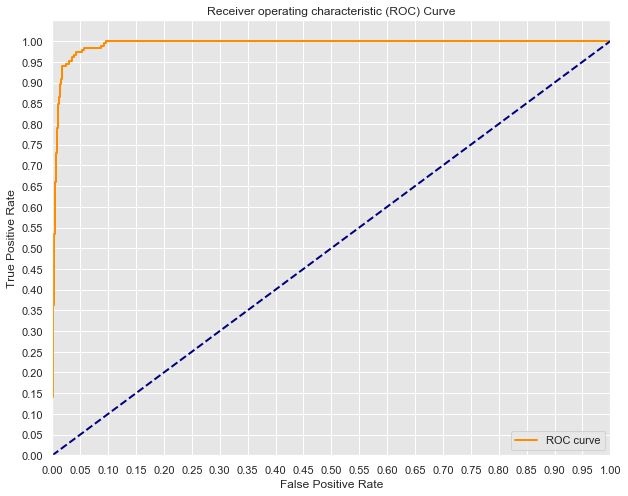

In [64]:
y_score = gbt_clf.fit(X_train, y_train).decision_function(X_test)
#False positive Rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Most Important Features and Graphs
The most important features used to distinguish between fraudulent and non-fraudulent filings were the Length of the Financial Statement and the KL Divergence from Benford's Law.

<p align="center">
<img  src="images/importance.png">

### Benford's Law Revisited
A company's deviation from Benford's Law was a good feature to indicate if a Company had committed fraud, but not how I had hypothesized. According to my data, fraudulent filers tended to diverge less from Benford's Law than non-fraudulent filers. The amount of deviation was also dependent on the length of the financial statement.

<img  src="images/KLdiv.png">

### More important features graphed against each other:

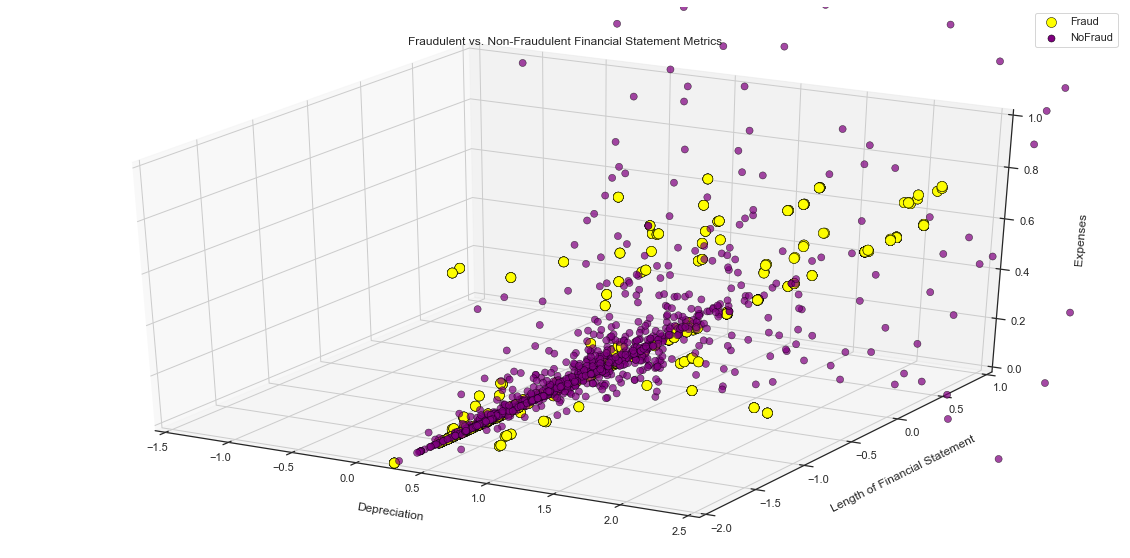

In [93]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fraud.Depreciation,fraud.sum_of_first_digits, fraud.Expenses, c='yellow', label='Fraud',s=100,linewidth=0.5, edgecolor='black')#raud.DEPI, 
ax.scatter(nofraud.Depreciation,nofraud.sum_of_first_digits, nofraud.Expenses,c='purple', s=50,linewidth=0.5, edgecolor='black',label='NoFraud')

plt.xlabel('Depreciation')
plt.xlim(-1.5, 2.5)
plt.ylabel("Length of Financial Statement")
plt.ylim(-2, 1)
ax.set_zlabel('Expenses')
ax.set_zlim(0,1)

plt.legend(loc='best')
plt.rcParams['lines.solid_capstyle'] = 'round'
plt.title("Fraudulent vs. Non-Fraudulent Financial Statement Metrics")
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20

### The three most important financial ratios graphed:

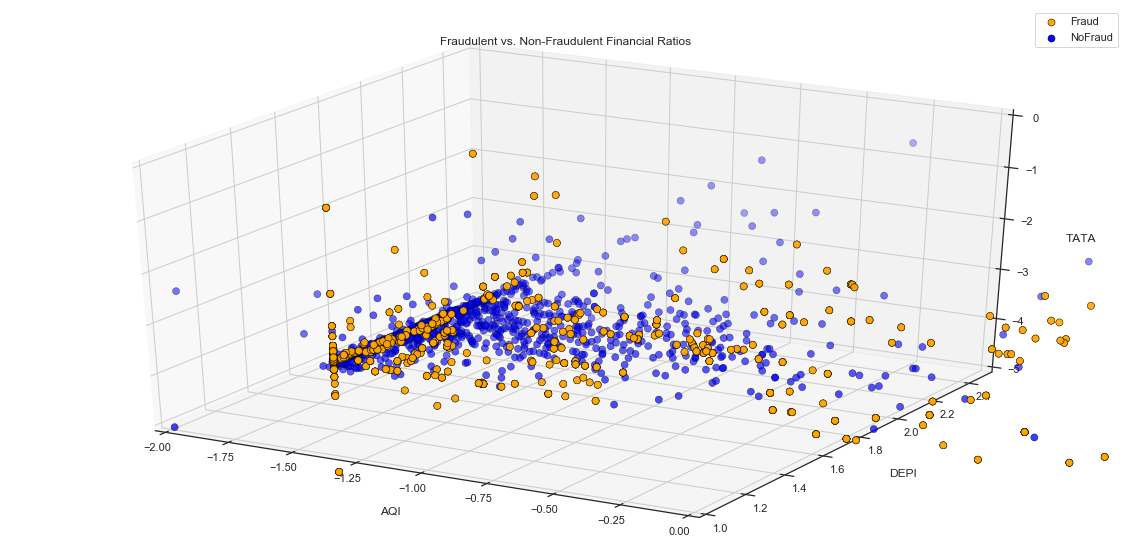

In [94]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(fraud.AQI,fraud.DEPI,fraud.TATA, c='orange', label='Fraud',s=50,linewidth=0.5, edgecolor='black')#raud.DEPI, 
ax.scatter(nofraud.AQI,nofraud.DEPI, nofraud.TATA,  c='blue', s=50,linewidth=0.5, edgecolor='black',label='NoFraud')


plt.xlabel('AQI')
plt.xlim(-2, 0)
plt.ylabel('DEPI')
plt.ylim(1, 2.5)
ax.set_zlabel('TATA')
ax.set_zlim(-5, 0)
plt.legend(loc='best')
plt.title('Fraudulent vs. Non-Fraudulent Financial Ratios')

plt.rcParams.update({'font.size': 16})
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20